# Importing Data

In [26]:
import pandas as pd

In [27]:
houses = pd.read_csv('/Users/merlesteffen/Documents/GitHub/HousingPrices/Data/housing-classification-iter-0-2.csv')

In [29]:
houses.isna().sum()

LotArea           0
LotFrontage     259
TotalBsmtSF       0
BedroomAbvGr      0
Fireplaces        0
PoolArea          0
GarageCars        0
WoodDeckSF        0
ScreenPorch       0
Expensive         0
dtype: int64

In [30]:
houses.describe().round(2)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
count,1460.00,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00
mean,10516.83,70.05,1057.43,2.87,0.61,2.76,1.77,94.24,15.06,0.15
std,9981.26,24.28,438.71,0.82,0.64,40.18,0.75,125.34,55.76,0.36
min,1300.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7553.50,59.00,795.75,2.00,0.00,0.00,1.00,0.00,0.00,0.00
50%,9478.50,69.00,991.50,3.00,1.00,0.00,2.00,0.00,0.00,0.00
75%,11601.50,80.00,1298.25,3.00,1.00,0.00,2.00,168.00,0.00,0.00
max,215245.00,313.00,6110.00,8.00,3.00,738.00,4.00,857.00,480.00,1.00


In [31]:
houses.sort_values(by='BedroomAbvGr', ascending=False)

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
635,10896,60.0,1440,8,0,0,0,0,0,0
570,13101,74.0,1728,6,0,0,2,0,0,0
1350,11643,91.0,1248,6,0,0,4,0,0,0
291,5687,55.0,780,6,0,0,0,0,0,0
144,9100,70.0,1728,6,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1163,12900,60.0,1198,0,0,0,2,120,0,0
53,50271,68.0,1842,0,1,0,3,857,0,1
189,4923,41.0,1593,0,1,0,2,0,224,1
634,6979,64.0,1056,0,0,0,2,264,0,0


In [62]:
houses.dropna(inplace=True)

In [63]:
houses

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive
0,8450,65.0,856,3,0,0,2,0,0,0
1,9600,80.0,1262,3,1,0,2,298,0,0
2,11250,68.0,920,3,1,0,2,0,0,0
3,9550,60.0,756,3,1,0,3,0,0,0
4,14260,84.0,1145,4,1,0,3,192,0,0
...,...,...,...,...,...,...,...,...,...,...
1455,7917,62.0,953,3,1,0,2,0,0,0
1456,13175,85.0,1542,3,2,0,2,349,0,0
1457,9042,66.0,1152,4,2,0,1,0,0,1
1458,9717,68.0,1078,2,0,0,1,366,0,0


# Train-Test Split

In [64]:
from sklearn.model_selection import train_test_split
features = ['LotArea', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces', 'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch']

X = houses[features]
y = houses['Expensive']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31416)

In [65]:
X_train

,LotArea,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch
1240,8158,884,3,0,0,2,0,0
632,11900,1386,3,1,0,2,192,0
838,9525,1099,3,0,0,1,278,0
196,9416,1726,3,1,0,3,171,266
548,8235,825,2,0,0,2,140,0
...,...,...,...,...,...,...,...,...
1034,6305,920,2,1,0,1,0,0
760,9100,864,2,0,0,1,0,0
302,13704,1541,3,1,0,3,468,0
815,12137,1649,3,0,0,2,0,0


We assume that the more above average a house is across these features, the more likely it is to be expensive.

# Z_Score Model

In [66]:
def intuitive_classifier(row):
    # Compute the z-score for each feature
    z_scores = (row - X_train.mean()) / X_train.std()
    
    # If the sum of the z-scores is above a threshold (let's say 4 for now), classify as expensive
    if z_scores.sum() > 5:
        return 1
    return 0

y_pred_train = X_train.apply(intuitive_classifier, axis=1)
y_pred_test = X_test.apply(intuitive_classifier, axis=1)


In [67]:
from sklearn.metrics import accuracy_score

print("Training Accuracy:", accuracy_score(y_train, y_pred_train))
print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))

Training Accuracy: 0.8479166666666667
Testing Accuracy: 0.9045643153526971


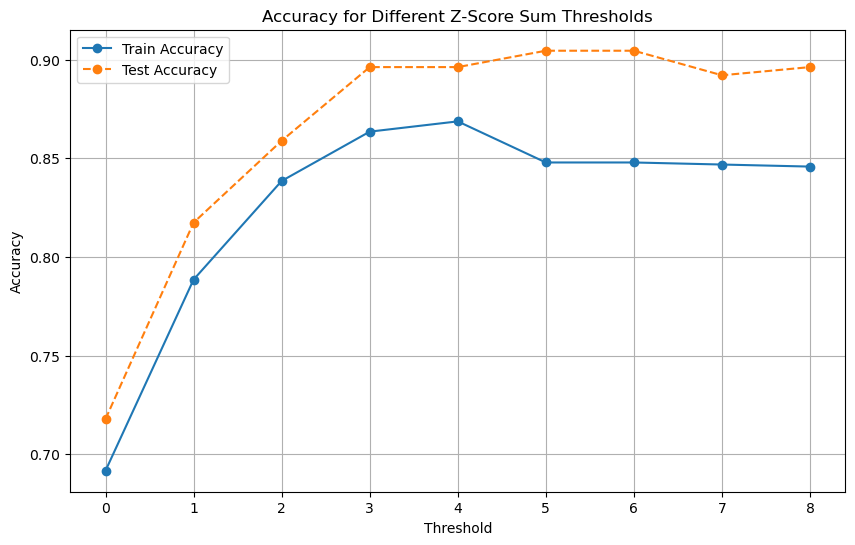

In [68]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Intuitive classifier function based on a threshold
def intuitive_classifier(row, threshold):
    z_scores = (row - X_train.mean()) / X_train.std()
    if z_scores.sum() > threshold:
        return 1
    return 0

# Compute accuracies for different thresholds
thresholds = list(range(0, 9))  # Thresholds from 0 to 8
train_accuracies = []
test_accuracies = []

for threshold in thresholds:
    y_pred_train = X_train.apply(intuitive_classifier, axis=1, threshold=threshold)
    y_pred_test = X_test.apply(intuitive_classifier, axis=1, threshold=threshold)
    train_accuracies.append(accuracy_score(y_train, y_pred_train))
    test_accuracies.append(accuracy_score(y_test, y_pred_test))

# Plot the results
plt.figure(figsize=(10,6))
plt.plot(thresholds, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(thresholds, test_accuracies, marker='o', linestyle='--', label='Test Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy for Different Z-Score Sum Thresholds')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
for column in houses.columns:
    plt.figure(figsize=(6, 6))
    sns.scatterplot(data=houses, x=column, y="Expensive", edgecolor=None, alpha=0.7)

    plt.title(f"Scatter plot of {column} and  Expensive")

    plt.show()

# Coding Rules - Model

In [55]:
# Initialize intuitive_model with 0 for all indices in X_train
intuitive_model = pd.Series(0, index=X_train.index)

# Rule 1: Houses with GarageCars >= 3 are considered expensive
intuitive_model.loc[X_train['GarageCars'] >= 3] = 1

# Rule 2: Houses with LotArea > 12,000 sqft are considered expensive
intuitive_model.loc[X_train['LotArea'] > 12000] = 1

# Rule 3: Houses with TotalBsmtSF > 1,300 sqft are considered expensive
intuitive_model.loc[X_train['TotalBsmtSF'] > 1300] = 1

# Rule 4: Houses with Fireplaces >= 2 or PoolArea > (mean + std) are considered expensive
intuitive_model.loc[(X_train['Fireplaces'] >= 2) | (X_train['PoolArea'] > (2.76 + 40.18))] = 1

# Rule 5: Houses with BedroomAbvGr between 4 and 6 are considered expensive
intuitive_model.loc[(X_train['BedroomAbvGr'] >= 4) & (X_train['BedroomAbvGr'] <= 6)] = 1

# Rule 6: Houses with a ScreenPorch are considered expensive
intuitive_model.loc[X_train['ScreenPorch'] > 0] = 1

# Rule 7: Houses with WoodDeckSF > 200 sqft are considered expensive
intuitive_model.loc[X_train['WoodDeckSF'] > 200] = 1
intuitive_model.head()

772    0
157    1
360    1
744    1
150    0
dtype: int64

In [56]:
# Accuracy
train_accuracy = accuracy_score(y_train, intuitive_model)
train_accuracy

0.5667808219178082

In [60]:
def above_average(row):
    z_score = (row-X_train.mean())/X_train.std()
    if z_score.sum() > 5:
        return 1
    else:
        return 0
    
predicted_expensive_train = X_train.apply(above_average, axis = 1) 
# The magic is in the .apply() method. When you use DataFrame.apply(func, axis=1), it applies the function func to each row of the DataFrame.
#For each row, the function computes the Z-Score. The axis=1 argument tells apply to operate row-wise. 
#If you used axis=0, it would operate column-wise.
predicted_expensive_test = X_test.apply(above_average, axis = 1)
#The apply() method creates a new pandas Series that collects each return value from the function for each row it processes. 
#This is then stored in the variable you assign the result to, such as predicted_expensive_train or predicted_expensive_test.

In [61]:
from sklearn.metrics import accuracy_score

print("Training Accuracy:", accuracy_score(y_train, predicted_expensive_train))
print("Testing Accuracy:", accuracy_score(y_test, predicted_expensive_test))

Training Accuracy: 0.8613013698630136
Testing Accuracy: 0.8972602739726028
